In [1]:
import sys
sys.path.append('../60_gebastel/Model/')
sys.path.append('../30_data_tools/')

In [64]:
import torch
from torchvision import models, transforms
from io import BytesIO
from pytorch_model_tools import get_datasets
from file_interaction import download_blob
from tqdm.auto import tqdm
import plotly.express as px
import numpy as np
import pickle
import math
import pandas as pd
import re

## noch offen

- ROC-Kurve/Area under Curve

0 = moire, 1 = no moire

In [3]:
def load_data( model_results_name ):
    data = pickle.loads( download_blob(f'modeL_results/{ model_results_name }.pkl').getbuffer() )
    data.rename(columns={'category':'label'}, inplace=True)
    
    data.loc[:,'predicted_label'] = (data.result_moire < data.result_no_moire).astype('int').apply(lambda val: ['moire','no_moire'][val])
    data.loc[:,'classification_correct'] = data.predicted_label == data.label

    return data

In [4]:
def calc_metrics( data ):
    TP = data.loc[(data.label == 'moire') & (data.predicted_label == 'moire')].shape[0]
    TN = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'no_moire')].shape[0]
    FP = data.loc[(data.label == 'no_moire') & (data.predicted_label == 'moire')].shape[0]
    FN = data.loc[(data.label == 'moire') & (data.predicted_label == 'no_moire')].shape[0]

    out = {
        "count_data" : data.shape[0],
        "TP" : TP,
        "TN" : TN,
        "FP" : FP,
        "FN" : FN,
        "TN-Rate" : 0,
        "TP-Rate" : 0,
        "accuracy" : 0,
        "precision" : 0,
        "recall" : 0
    }
    
    if (FP + TN) > 0:
        out["TN-Rate"] = TN / (FP + TN)

    if (FN + TP) > 0:
        out["TP-Rate"] = TP / (FN + TP)

    if out['count_data'] > 0:
        out["accuracy"] = (TP + TN) / out['count_data']

    if (TP + FP) > 0:
        out["precision"] = TP / (TP + FP)

    if (TP + FN) > 0:
        out["recall"] = TP / (TP + FN)
    

    return out

In [5]:
def get_confusion_matrix( metrics, relative=False ):
    values = np.array([
        [metrics['TP'],metrics['FN']],
        [metrics['FP'],metrics['TN']]
    ])

    if relative:
        values = values / metrics['count_data']
    
    return px.imshow(
        values,
        x=['moire','no_moire'],
        y=['moire','no_moire'],
        labels={
            'y' : 'label',
            'x' : 'prediction'
        },
        text_auto=True
    )

In [6]:
model_name = '2024-05-02_Resnet50_001'
dataset_name = '24-05-02_001_tile_dataset'

In [7]:
data = load_data(f"{ model_name }_{ dataset_name }")

In [12]:
metrics = {}

for dataset in data.dataset.unique():
    metrics[dataset] = calc_metrics( data.loc[data.dataset == dataset] )

In [162]:
metrics_df = pd.DataFrame.from_dict([metrics[key] for key in metrics])
metrics_df.loc[:,'dataset'] = [key for key in metrics]
metrics_df.set_index('dataset', inplace=True)

metrics_df.T.loc[:,['test','real_val']]

dataset,test,real_val
count_data,30852.000000,7440.000000
TP,10727.000000,2601.000000
TN,14708.000000,1850.000000
FP,3020.000000,882.000000
FN,2397.000000,2107.000000
TN-Rate,0.829648,0.677160
TP-Rate,0.817358,0.552464
accuracy,0.824420,0.598253
precision,0.780316,0.746770
recall,0.817358,0.552464


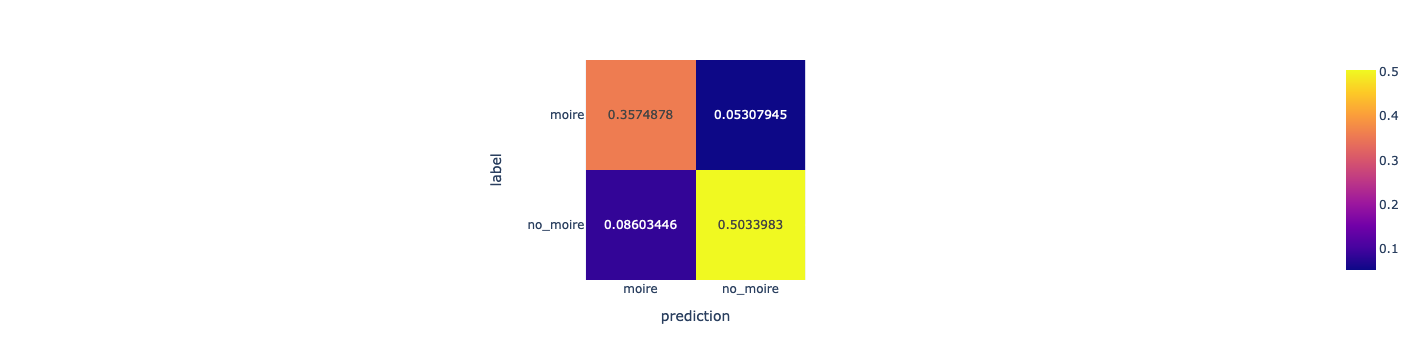

In [52]:
get_confusion_matrix( metrics['train'], relative=True )

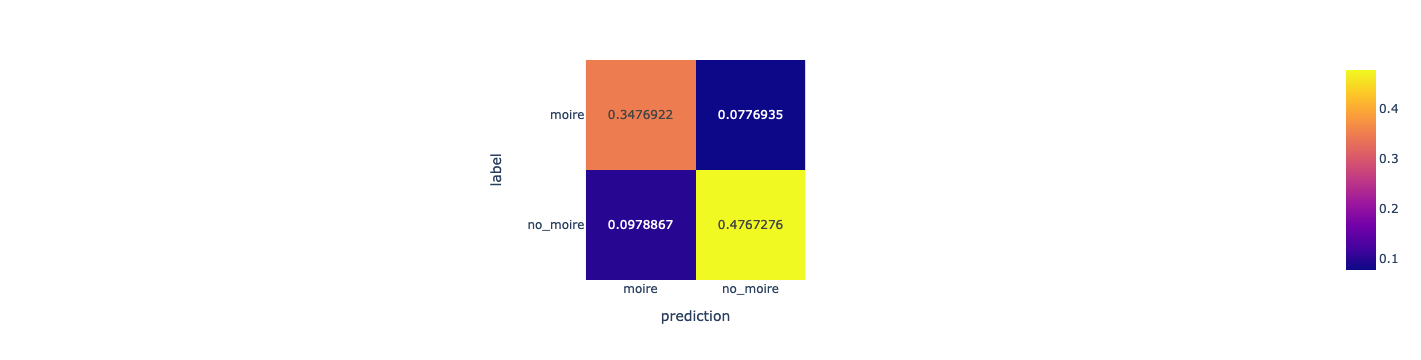

In [53]:
get_confusion_matrix( metrics['test'], relative=True )

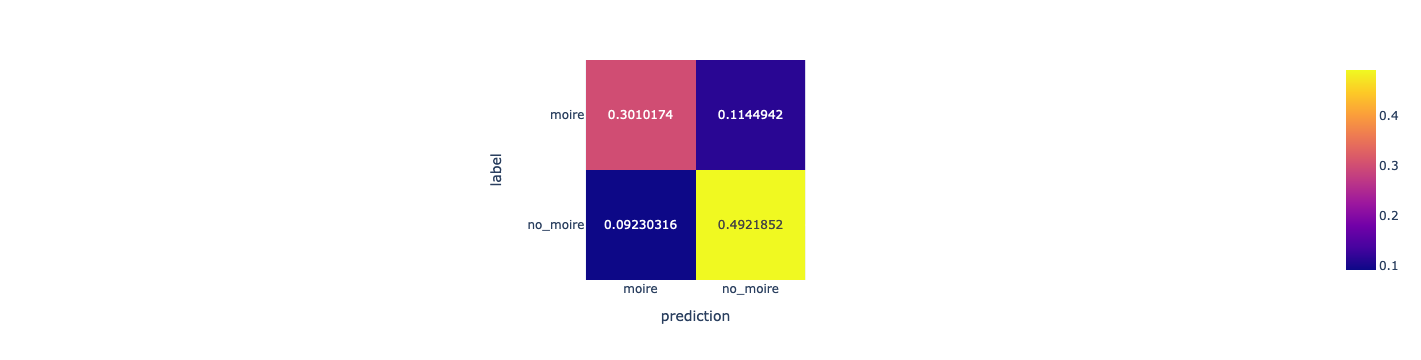

In [54]:
get_confusion_matrix( metrics['val'], relative=True )

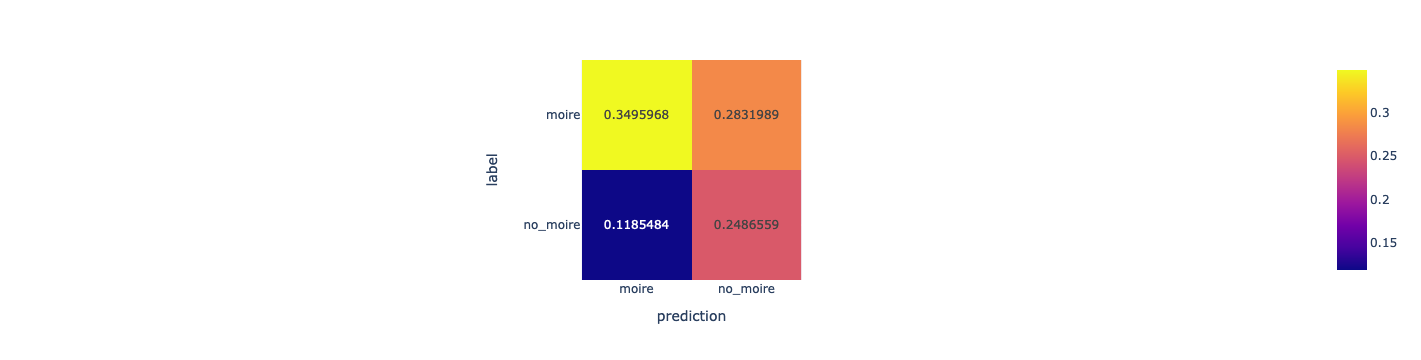

In [55]:
get_confusion_matrix( metrics['real_val'], relative=True )

# Kacheldataset

In [69]:
tile_dataset = pd.merge(
    data,
    data.tile_name.str.extract('(.+)_(\d+)\.\d+\.jpg').rename(columns={0:'mask_id',1:'dpi'}),
    left_index=True,
    right_index=True
)

In [155]:
grouped_tile_dataset = tile_dataset.loc[
    :,
    ['mask_id','dataset','label','dpi','predicted_label']
].groupby(['mask_id','label','dpi']).min().reset_index()
grouped_tile_dataset = grouped_tile_dataset.groupby(['mask_id','label']).agg(pd.Series.mode).reset_index().drop(columns=['dpi'])
grouped_tile_dataset = grouped_tile_dataset.loc[
    grouped_tile_dataset.predicted_label.apply(lambda val: type(val) == str)
]

In [159]:
calc_metrics( data.loc[data.dataset == 'test'] )

{'count_data': 30852,
 'TP': 10727,
 'TN': 14708,
 'FP': 3020,
 'FN': 2397,
 'TN-Rate': 0.8296480144404332,
 'TP-Rate': 0.8173575129533679,
 'accuracy': 0.8244198107091922,
 'precision': 0.7803157052447807,
 'recall': 0.8173575129533679}

In [158]:
calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'test'])

{'count_data': 272,
 'TP': 133,
 'TN': 44,
 'FP': 91,
 'FN': 4,
 'TN-Rate': 0.32592592592592595,
 'TP-Rate': 0.9708029197080292,
 'accuracy': 0.6507352941176471,
 'precision': 0.59375,
 'recall': 0.9708029197080292}

In [160]:
calc_metrics( data.loc[data.dataset == 'real_val'] )

{'count_data': 7440,
 'TP': 2601,
 'TN': 1850,
 'FP': 882,
 'FN': 2107,
 'TN-Rate': 0.6771595900439239,
 'TP-Rate': 0.552463891248938,
 'accuracy': 0.598252688172043,
 'precision': 0.7467700258397932,
 'recall': 0.552463891248938}

In [157]:
calc_metrics(grouped_tile_dataset.loc[grouped_tile_dataset.dataset == 'real_val'])

{'count_data': 192,
 'TP': 94,
 'TN': 36,
 'FP': 58,
 'FN': 4,
 'TN-Rate': 0.3829787234042553,
 'TP-Rate': 0.9591836734693877,
 'accuracy': 0.6770833333333334,
 'precision': 0.618421052631579,
 'recall': 0.9591836734693877}

# Rest

In [ ]:
from PIL import Image
from PIL import ImageFont, ImageDraw  
from pathlib import Path

In [ ]:
results = []

for tile_path in tqdm(tile_paths):
    tile = Image.open(tile_path)
    transform = transforms.Compose([transforms.PILToTensor()])

    tensor = transform(tile) / 255
    tensor = tensor.reshape((1,3,224,224))
    with torch.no_grad():
        pred = model(tensor)

    results.append((
        tile_path,
        pred,
        int(torch.argmax(pred))
    ))

In [ ]:
font = ImageFont.load_default()

In [ ]:
IMG_SIZE = 224

label_names = ['moire','no_moire']
grid_size = (5,5)

offset = 0

while offset < len(results):
    out_img = Image.new(
        'RGB',
        (IMG_SIZE * grid_size[0], IMG_SIZE * grid_size[1]),
        color="white"
    )
    draw = ImageDraw.Draw(out_img)  
    label_color=[
        (0,200,0),
        (200,0,50)
    ]
    
    for y in range(grid_size[1]):
        for x in range(grid_size[0]):
            i = y * grid_size[1] + x
    
            if len(results) > offset + i:
                result = results[offset+i]
                label = result[0].parent.name
                target_label = label_names[result[2]]
                
                tile_img = Image.open( result[0] )
                out_img.paste(
                    tile_img,
                    ( x * tile_img.size[0], y * tile_img.size[1] )
                )
                draw.rectangle(
                    (
                        ( x * tile_img.size[0], y * tile_img.size[1] + round(IMG_SIZE * 0.9) ),
                        ( x * tile_img.size[0] + IMG_SIZE, y * tile_img.size[1] + IMG_SIZE )
                    ),
                    outline=None,
                    fill=label_color[0] if label == target_label else label_color[1]
                )
                draw.text(
                    ( x * tile_img.size[0] + round(IMG_SIZE * 0.5), y * tile_img.size[1] + round(IMG_SIZE * 0.97) ),
                    f'{ label }/{ target_label }',
                    anchor='ms',
                    font_size=15
                )
                
    offset += 50
    out_img.save( f'/Users/frederic.birwe/Downloads/tile_grid_{ (str(offset)).zfill(3) }.jpg' )

out_img

In [ ]:
results